# Create Knowledgebase

## Notes

- Check for missing dependencies (especially ones only added in the ingestion phase currently)
- Check for multi-core processing for SBert models, seems to only use one core right now

## TODO

- Check results from DB without reranker vs no-reranker
- Check token sizes / limits for Sentence Transformer / Bi-Encoder (also check used models again, mentioned parameters depend on those)
- Check why `title` is incorrect in last crawls
- Overall: check quality of crawled content per domain before ingesting

## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
%pip install top2vec "top2vec[sentence_encoders]" jsonlines

## Create topics model

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

In [4]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw'].replace('\n', ' ')

documents = list()
with jsonlines.open('pages-kickstartDS_com_extracted_sections.jsonl', 'r') as pages:
    for page in pages:
        for section in page['sections']:
            documents.append(section['title'].replace('\n', ' ') + ' ' + section['heading'].replace('\n', ' ') + ' ' + section['content'].replace('\n', ' '))
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8)

print()
print(str(model.get_num_topics()) + ' topics discovered.')


2023-03-10 20:54:39,380 - top2vec - INFO - Pre-processing documents for training


583 documents added for topic generation.


2023-03-10 20:54:39,601 - top2vec - INFO - Creating joint document/word embedding
2023-03-10 20:55:03,391 - top2vec - INFO - Creating lower dimension embedding of documents
2023-03-10 20:55:09,770 - top2vec - INFO - Finding dense areas of documents
2023-03-10 20:55:09,789 - top2vec - INFO - Finding topics



2 topics discovered.


## (Optionally) save topic model

You can save the Top2Vec model created in the step before with this.

In [6]:
model.save("top2vec.model")

## (Optionally) load topic model

You can also load a previously generated Top2Vec topic model.

In [2]:
from top2vec import Top2Vec

model = Top2Vec.load("top2vec.model")

## Start querying topics

With the model for Top2Vec in place, you can start querying it:
https://github.com/ddangelov/Top2Vec


Top 5 topics returned for keyword search "component" as a word cloud (scroll down):

Top 5 words by similarity to keyword "component":
example 0.7640104819801177
api 0.7537215990817951
properties 0.6886180641830436
adding 0.6870875397940548
base 0.6785153095123005

Top 5 sections for topic 0:
Document: 547, Score: 0.6307798027992249
-----------
https://www.kickstartDS.com/docs/intro/environment Working with the terminal Working with a Design System code base in general, and with kickstartDS specifically, often involve working with your local terminal. We can't give you an exhausting intro to that here, but the MDN one is a good start: Understanding client-side web development tools > Command line crash course Generally your best starting point is the built-in terminal, included with most Operating Systems (OS). There's nothing prohibiting you from using other terminal solutions or configurations, but if you happen to come accross something strange feel free to open a ticket on Github.

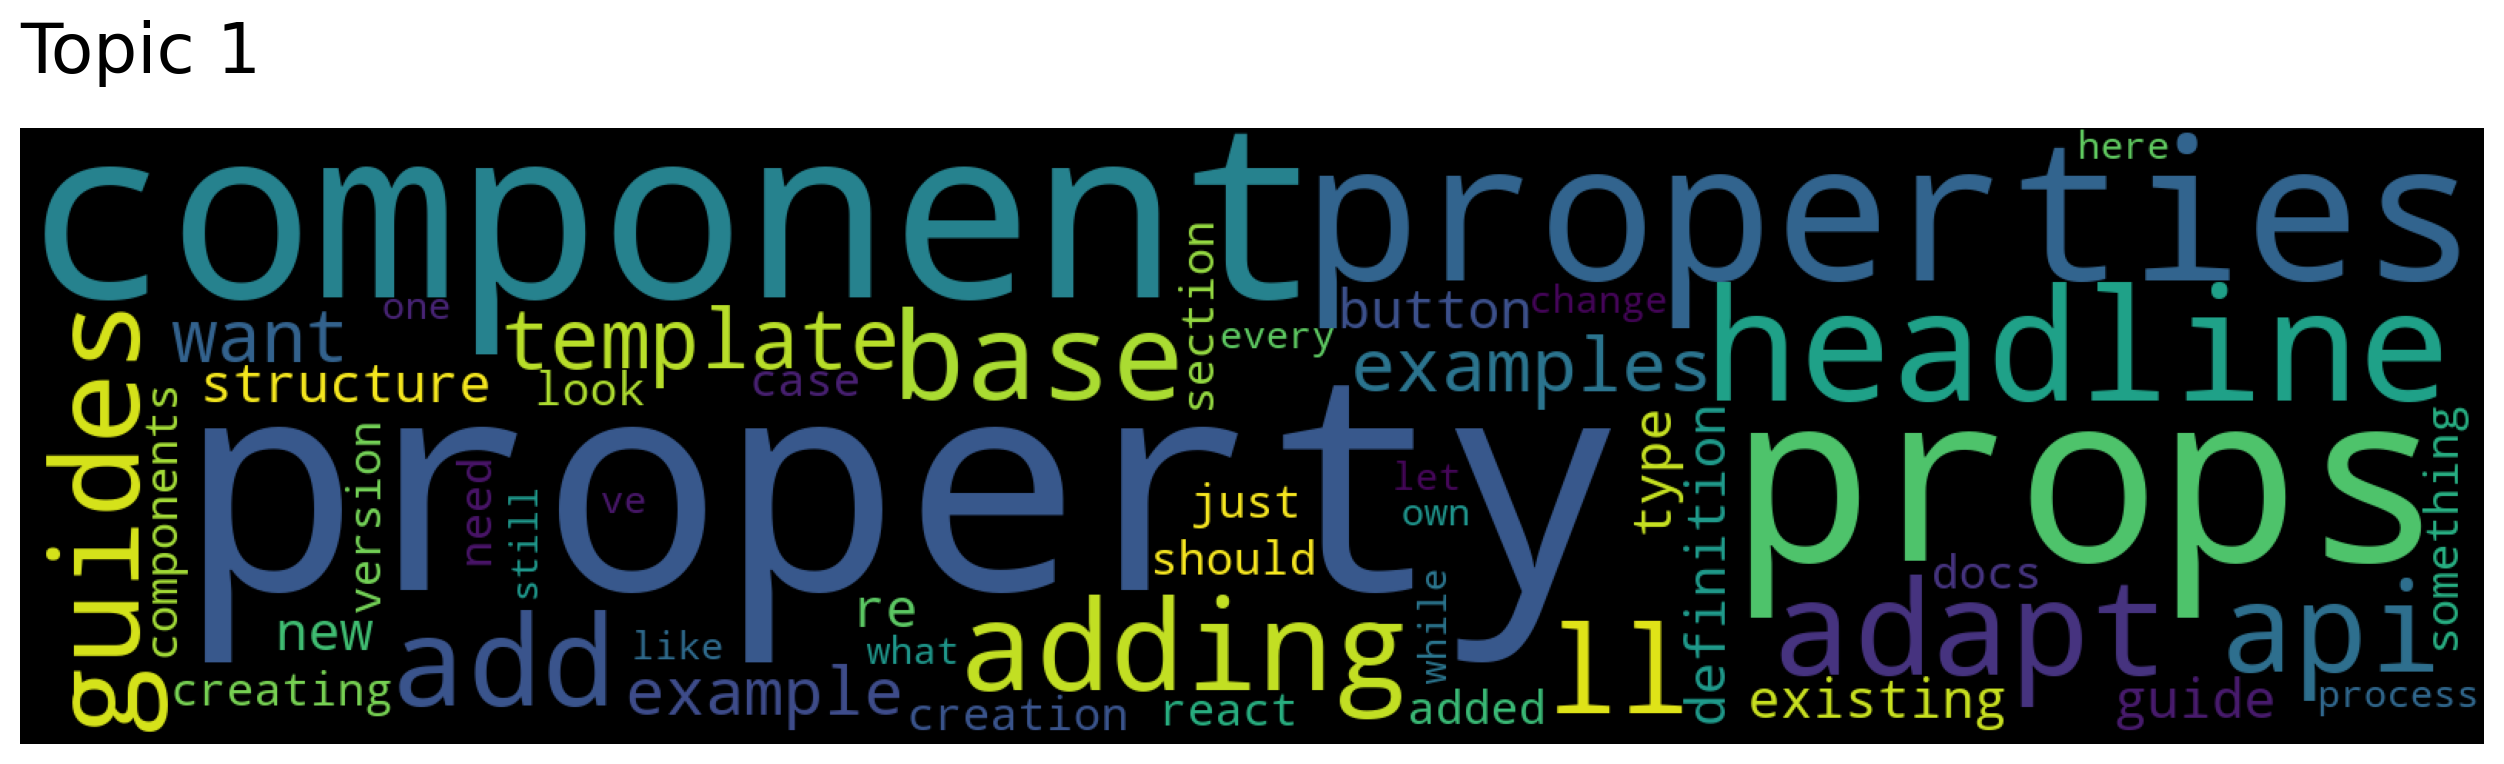

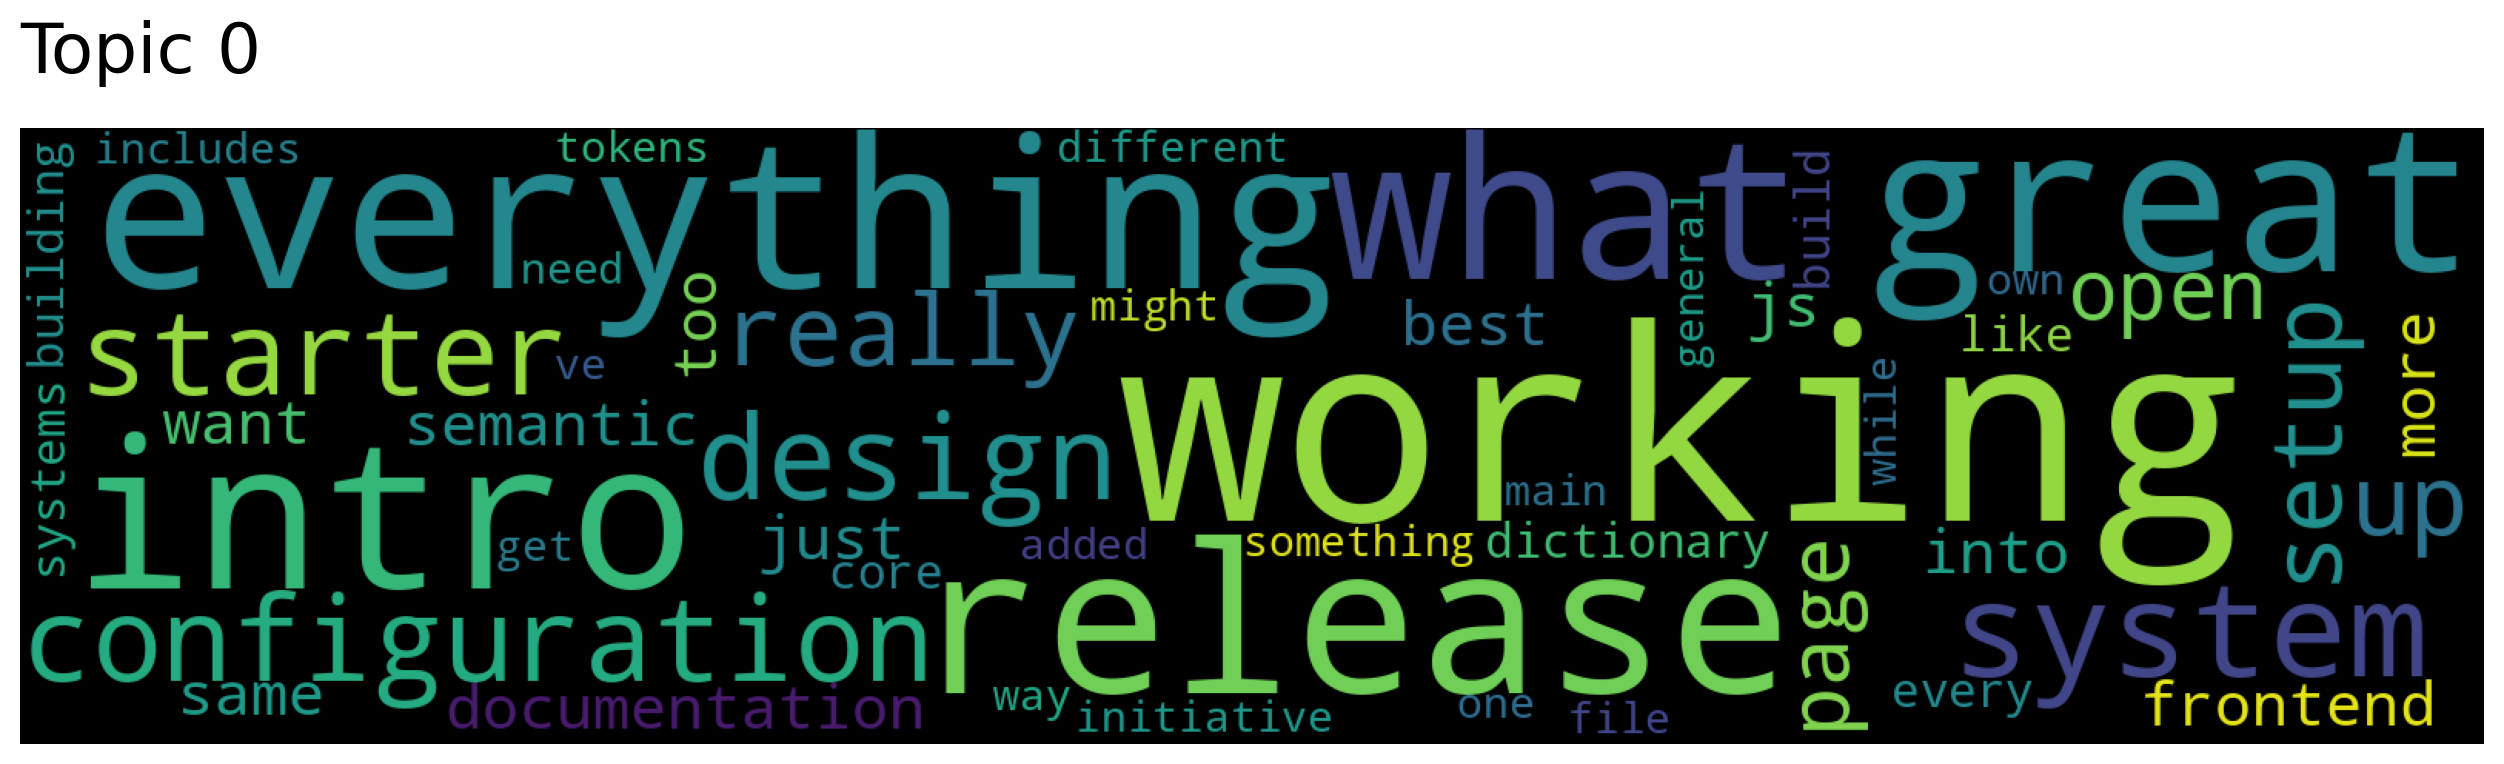

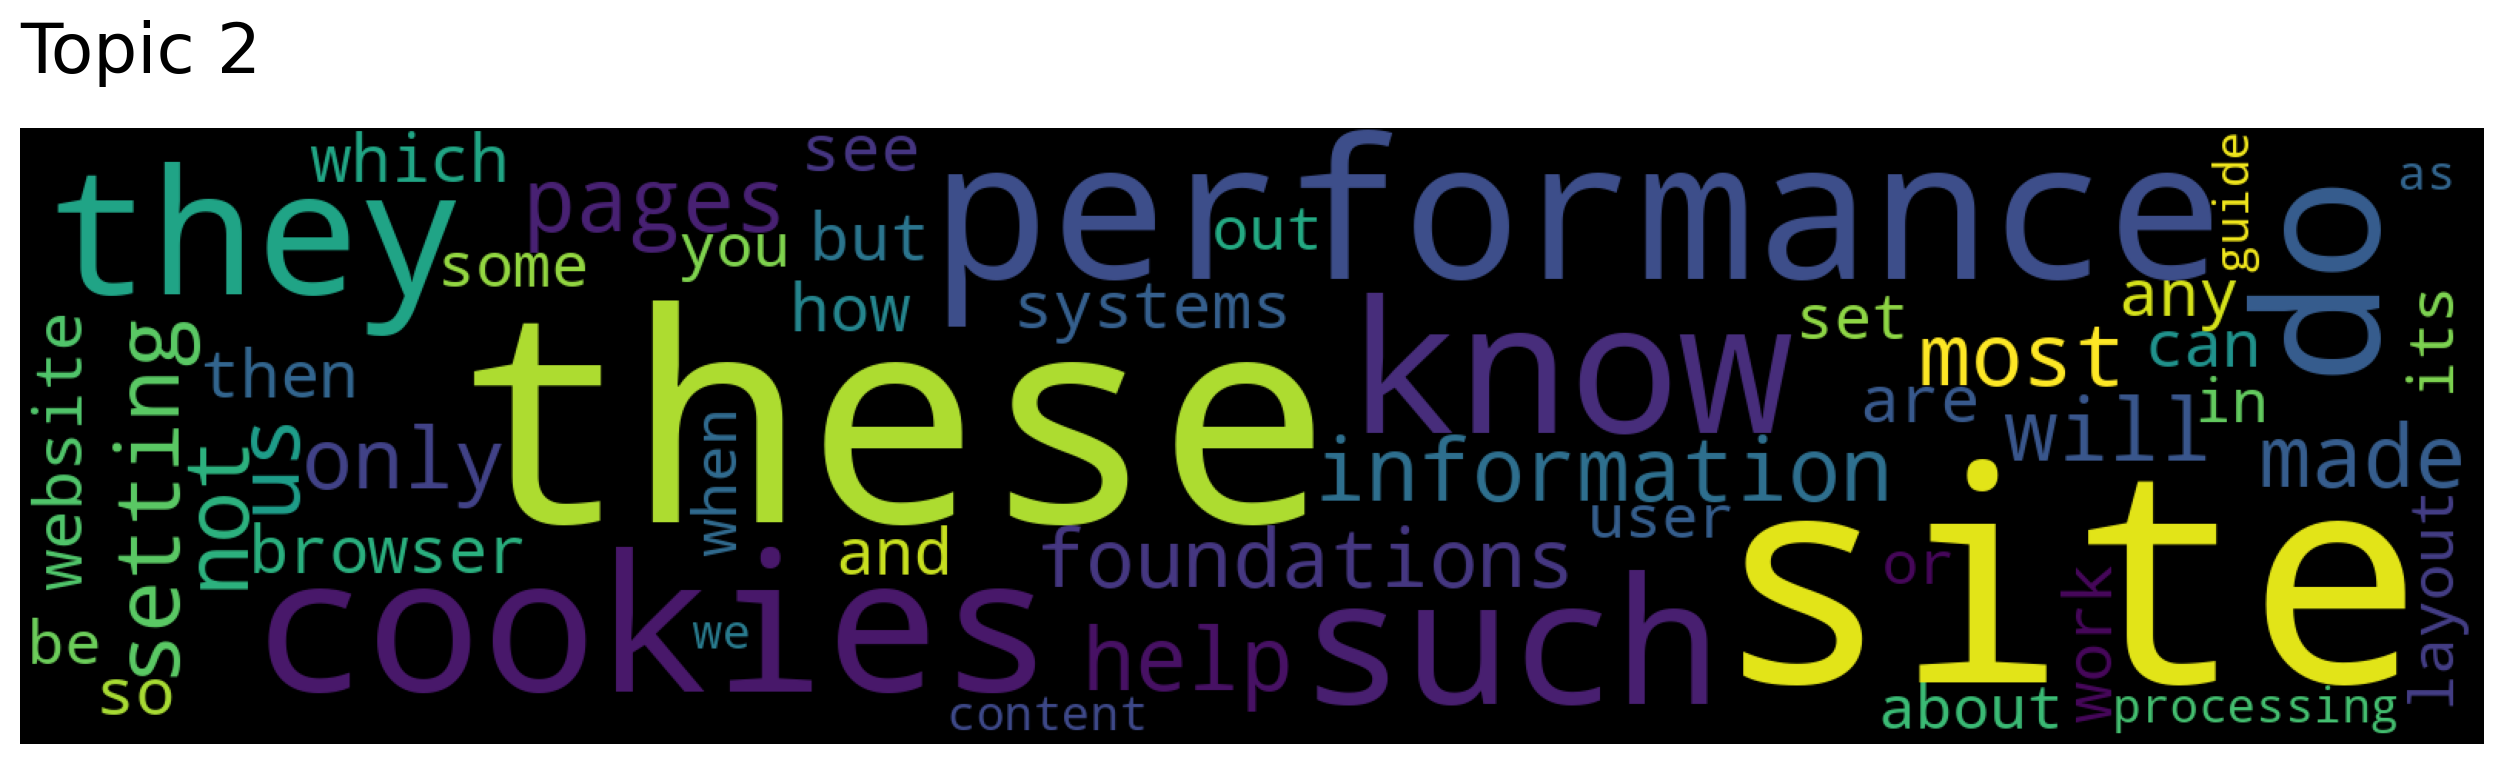

In [17]:
print()
print('Top 5 topics returned for keyword search "component" as a word cloud (scroll down):')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["component"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 5 words by similarity to keyword "component":')
words, word_scores = model.similar_words(keywords=["component"], keywords_neg=[], num_words=5)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 5 sections for topic 0:')
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()
  
print()
print('Top 5 documents for keywords "component" and "create":')
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["component", "create"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

## Top 50 topics word clouds

This generates a word cloud for the 50 most relevant topics in this knowledge base.

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(50)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

## Create knowledge base

Create a knowledge base using SBert and Sentence Transformers, based on the sections of ingested pages.

This is can all still be done completely "offline", and without any third party APIs.

In [71]:
import torch
import jsonlines
from sentence_transformers import SentenceTransformer

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook.")
    
print('Creating SBert knowledge base.')    

bi_encoder = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
bi_encoder.max_seq_length = 256

def getSectionContent(section):
    return section['heading'].replace('\n', ' ') + ': ' + section['content'].replace('\n', ' ')

sections = []
with jsonlines.open('pages-kickstartDS_com_extracted_sections.jsonl', 'r') as pages:
    for page in pages:
        for page_section in page['sections']:
            section = dict()
            section['page'] = dict()
            section['page']['url'] = page['url']
            section['page']['title'] = page['title']
            section['page']['summary'] = page['summaries']['sbert']
            section['heading'] = page_section['heading']
            section['content'] = page_section['content']
            sections.append(section)

passages = []
passages.extend(map(getSectionContent, sections))

print('Passages:', len(passages))

corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True)

print('Corpus embeddings created.')
print('Corpus embedding size:', corpus_embeddings.shape)

Creating SBert knowledge base.
Passages: 583
Corpus embeddings created.
Corpus embedding size: torch.Size([583, 768])


## Define (offline) search function

This function will search through our corpus, and retrieve the most relevant sections in relation to the user query given as a parameter.

In [11]:
from sentence_transformers import CrossEncoder, util

top_k = 32
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def search(query):
    print("Input question:", query)

    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    # Change back to .cuda() when GPU is available on Codespace
    question_embedding = question_embedding.cpu()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]

    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))

## Run queries against (offline) knowledge base

Using the "search" function defined before we can start querying our knowledge base.

In [12]:
search("What is a Design System?")

Input question: What is a Design System?

-------------------------

Top-5 Cross-Encoder Re-ranker hits
	8.710	https://www.kickstartDS.com/docs/guides/design-system-initiative: A Design System Initiative is the process an organization undertakes when considering to initialize a Design System. This generally occurs in a couple of steps where usually different kinds of workshops are run. It starts way before the pure design and development process itself by impacting many disciplines and stakeholders within the organization.
	8.474	https://www.kickstartDS.com/blog/everything-meta-and-everything-matters/: A design system meta framework is a set of guidelines, principles and best practices that are used to create, maintain, and evolve a Design System. A Design System is a collection of standardized design elements, such as colors, typography, iconography, and components, that are used to create a consistent, high-quality user experience across multiple products and platforms. In this sense

# Database

## Install DB dependencies

We'll need `psycopg` for the connection, and `pgvector` to register the vector type for our embeddings to the PostgreSQL connection.

We also use `python-dotenv` to load our environment, namely the `DB_PASS` for the database connection. Ensure settings this variable in your environment, or add a `.env` file next to the notebook where the variable is defined to avoid putting it into your host context.

In [ ]:
%pip install psycopg pgvector python-dotenv

## Connect to DB

Establish a connection with the database.

In [104]:
from dotenv import load_dotenv
from pgvector.psycopg import register_vector
import psycopg
import os

load_dotenv()

conn_string = "dbname=postgres user=postgres password=" + os.getenv('DB_PASS') + " host=db.pzdzoelitkqizxopmwfg.supabase.co port=5432"
conn = psycopg.connect(conn_string, row_factory=psycopg.rows.dict_row)
conn.autocommit = True
conn.execute('CREATE EXTENSION IF NOT EXISTS vector')
register_vector(conn)

## Write embeddings to DB

Write all page embeddings into PostgreSQL / pgvector / Supabase.

In [73]:
from datetime import datetime

seed = True
timestamp = datetime.now()

# Change back to .cuda() when GPU is available on Codespace
page_embeddings = corpus_embeddings.cpu()

if seed:
    conn.execute('DROP TABLE IF EXISTS page')
    conn.execute('CREATE TABLE page (id bigserial primary key, created_at timestamptz, updated_at timestamptz, page_url text, page_title text, page_summary text, heading text, content text, embedding vector(768))')

    for index, page_embedding in enumerate(page_embeddings.detach().numpy()):
        conn.execute("""
            INSERT INTO page (created_at, updated_at, page_url, page_title, page_summary, heading, content, embedding)
            VALUES (%(created_at)s, %(updated_at)s, %(page_url)s, %(page_title)s, %(page_summary)s, %(heading)s, %(content)s, %(embedding)s);
        """, ({
            'created_at': timestamp,
            'updated_at': timestamp,
            'page_url': sections[index]['page']['url'],
            'page_title': sections[index]['page']['title'],
            'page_summary': sections[index]['page']['summary'],
            'heading': sections[index]['heading'],
            'content': sections[index]['content'],
            'embedding': page_embedding
        }))

    conn.execute('CREATE INDEX ON page USING ivfflat (embedding vector_cosine_ops)')

## Define (online) search function

This function can be used to run a search against the PostgreSQL vector table.

In [109]:
from sentence_transformers import CrossEncoder

top_k = 32
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def search(query):
    print("Input question:", query)

    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    # Change back to .cuda() when GPU is available on Codespace
    question_embedding = question_embedding.cpu()

    hits = conn.execute('SELECT * FROM page ORDER BY embedding <-> %s LIMIT ' + top_k, (question_embedding.detach().numpy(),)).fetchall()

    cross_inp = [[query, hit['content']] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits from PostgreSQL")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}\t{}".format(hit['cross-score'], hit['heading'], hit['content']))


In [108]:
search('What is a Design System?')

Input question: What is a Design System?

-------------------------

Top-5 Cross-Encoder Re-ranker hits from PostgreSQL
	9.729	Not to forget: a Design System is nothing without systems using it!	A Design System is there to generate value, to support the organization to better reach its objectives. Naturally there will be product or feature teams using it. About that, a 6th Step could and maybe even should be added to the setup process of the Design System.
	8.897	But first, what is a design system?	To provide some shared framing, what we refer to when speaking about design systems is a library of coded components which itself is usually part of a broader platform of shared principles, processes, tools and assets, typically the brand portal of a company. The design system serves as the single point of truth and empowers digital teams to create seamless, brand-consistent and unified experiences. Here is NN/g: Nielsen Norman Group’s description: Design Systems – also known as “pattern lib

## Close DB connection

After we're done, we'll close down the connection to PostgreSQL again.

In [102]:
conn.close()